In [1]:
from Basin import Basin 
from functions import compute_contacts, get_epi_params, compute_contacts_factor, get_epi_params, get_IFR_fixed
from deaths import compute_deaths
from functions import apply_seasonality
from stochastic_SEIRD import simulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

start_date = datetime(2020, 11, 1)
end_date = datetime(2021, 10, 1)

country = "Afghanistan"
basin = Basin(country, "../basins/")
Cs, dates = compute_contacts(basin, start_date, end_date)


In [2]:
epi_params = get_epi_params()
IFR = get_IFR_fixed('verity')

epi_params["Delta"] = 20
epi_params["IFR"] = IFR * 2
epi_params["IFR_VOC"] = IFR * 2

In [3]:
import time 

start = time.time()
results = simulate(basin=basin, 
                   Cs=Cs, 
                   R0=1.28,
                   Delta=epi_params["Delta"], 
                   dates=dates,
                   seasonality_min=0.7,
                   vaccine='age-order', 
                   I_mult=3, 
                   R_mult=5, 
                   psi=1.9, 
                   vaccinations=basin.vaccinations,
                   date_VOC_intro=basin.start_date_VOC+timedelta(days=0))

results_deaths = compute_deaths(results["recovered"],
                                    results["recovered_VOC"],
                                    results["recovered_V1i"],
                                    results["recovered_V2i"],
                                    results["recovered_V1i_VOC"],
                                    results["recovered_V2i_VOC"],
                                    epi_params)

results.update(results_deaths)

print(time.time() - start)

1.0426721572875977


/Users/nicolo/Desktop/vaccine-lmic/models/deaths.py:61: RuntimeWarning: invalid value encountered in true_divide
  ifr[age] = (deaths[age]) / (R[age] + R_V1[age] + R_V2[age] + R_VOC[age] + R_V1_VOC[age] + R_V2_VOC[age])
/Users/nicolo/Desktop/vaccine-lmic/models/deaths.py:69: RuntimeWarning: invalid value encountered in true_divide
  ifr_tot = tot_deaths / tot_rec


<ipython-input-4-0f51a66e926b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deaths["daily_sim"] = results["deaths_TOT"].sum(axis=0)


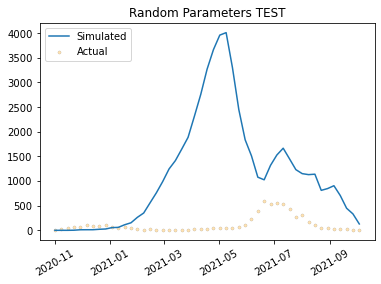

In [4]:
df_deaths = basin.epi_data_deaths
df_deaths = df_deaths.loc[(df_deaths.date >= dates[0]) & (df_deaths.date <= dates[-1])]
df_deaths["daily_sim"] = results["deaths_TOT"].sum(axis=0)

df_deaths.index = df_deaths.date
df_deaths_w = df_deaths.resample("W").sum()

plt.plot(df_deaths_w.index, df_deaths_w.daily_sim, label='Simulated')
plt.scatter(df_deaths_w.index, df_deaths_w.daily, s=10, alpha=0.3, linewidth=0.3, edgecolor='k', color='orange', label='Actual')
plt.xticks(rotation=30)

plt.title('Random Parameters TEST')
plt.legend(loc='upper left');